In [31]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from functools import partial
import fastcore.all as fc
from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

In [1]:
from miniminiai import *

In [6]:
from datasets import load_dataset

In [21]:
import torchvision.transforms.functional as TF

In [32]:
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

In [9]:
x,y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)

Using the latest cached version of the module from /home/pro0/.cache/huggingface/modules/datasets_modules/datasets/fashion_mnist/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48 (last modified on Sun Oct 15 10:00:50 2023) since it couldn't be found locally at fashion_mnist., or remotely on the Hugging Face Hub.


In [10]:
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [23]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o) , (32,32), antialias=True) for o in b[x]]

In [29]:
# set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb, yb = next(iter(dt))

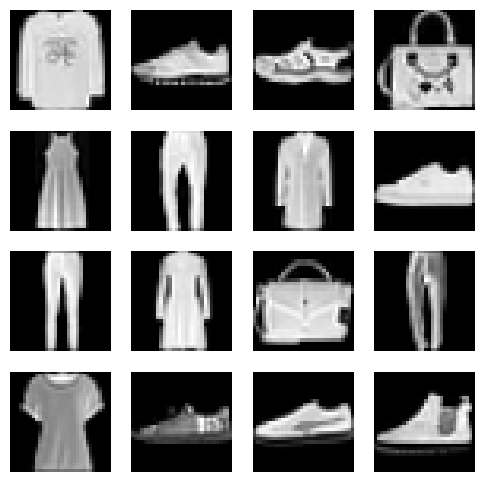

In [33]:
show_images(xb[:16], imsize=1.5)

In [13]:
DataLoaders??

In [27]:
from diffusers import UNet2DModel

In [28]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32,64, 128,128 ))

In [34]:
betamin, betamax, n_steps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1. - beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

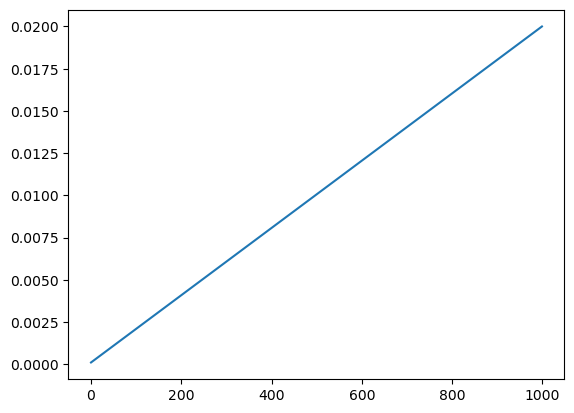

In [35]:
plt.plot(beta);

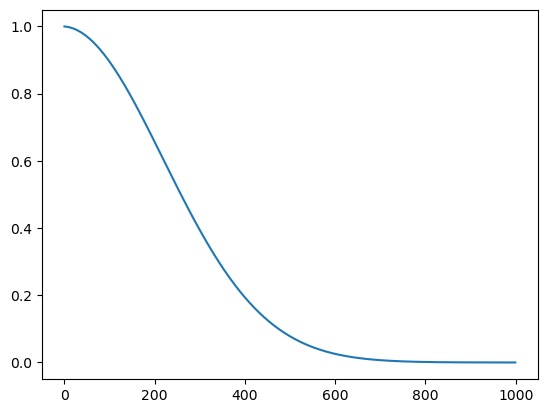

In [37]:
plt.plot(alphabar);

In [43]:
class DDPMCB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.alpha = 1-self.beta
        self.alphabar = self.alpha.cumprod(dim=0)
        self.sigma = self.beta.sqrt()
    
    def predict(self, learn): learn.preds = learn.model(*learn.batch[0]).sample     
        
    def before_batch(self, learn):
        device = learn.batch[0].device
        eps = torch.randn(learn.batch[0].shape, device=device) # actual_noise
        x0 = learn.batch[0]
        self.alphabar = self.alphabar.to(device)
        n = x0.shape[0] # bs
        # select rand timesteps
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        alphabar_t = self.alphabar[t].reshape(-1,1,1,1)
        xt = alphabar_t.sqrt() + (1-alphabar_t).sqrt()*eps
        learn.batch = ((xt, t), eps)

In [100]:
# single batch
dlss = DataLoaders.from_dd(tds, 1, num_workers=4)
dt = dlss.train
xb, yb = next(iter(dt))

In [105]:
xb.shape

torch.Size([1, 1, 32, 32])

In [122]:
xb, yb = next(iter(dt))

In [123]:
# randomly selecting bs=1 timestamp
t = torch.randint(0, 1000, (1,), dtype=torch.long)
t

tensor([77])

In [137]:
alphabar[0]

tensor(0.9999)

In [ ]:
# like used in practice
alphabar_t = alphabar[t]

In [136]:
alphabar.argmax()

tensor(0)

In [124]:
# using greatest timestamp for less noise
alphabar.max()

tensor(0.9999)

In [126]:
alphabar_t = torch.tensor(0.9999)

In [127]:
alphabar_t.reshape(-1,1,1,1)

tensor([[[[0.9999]]]])

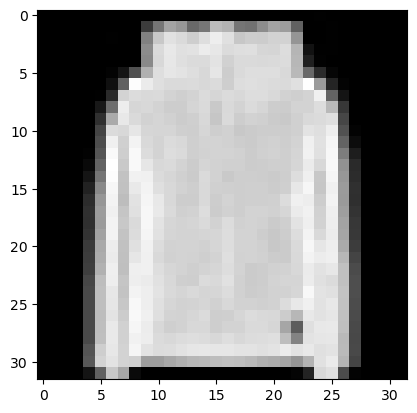

In [130]:
plt.imshow(TF.to_pil_image(a))

In [131]:
# image + noise
img = (alphabar_t.sqrt()*xb + (1-alphabar_t).sqrt()*torch.randn(xb.shape)).reshape(32,32)

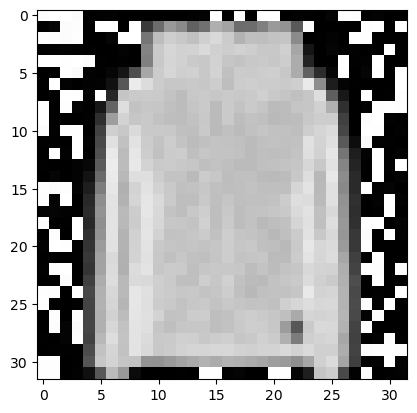

In [132]:
plt.imshow(TF.to_pil_image(img))